Making of the neural network, training of the neural network, and testing on various model happens here.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu

U-net model

In [2]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        #input: 1x256x3
        self.e11 = nn.Conv1d(3, 64, kernel_size=3, padding=1) # output: 1x256x64
        self.e12 = nn.Conv1d(64, 64, kernel_size=3, padding=1) # output: 1x256x64
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) # output: 1x128x64

        # input: 1x128x64
        self.e21 = nn.Conv1d(64, 128, kernel_size=3, padding=1) # output: 1x128x128
        self.e22 = nn.Conv1d(128, 128, kernel_size=3, padding=1) # output: 1x128x128
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2) # output: 1x64x128

        # input: 1x64x128
        self.e31 = nn.Conv1d(128, 256, kernel_size=3, padding=1) # output: 1x64x256
        self.e32 = nn.Conv1d(256, 256, kernel_size=3, padding=1) # output: 1x64x256
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2) # output: 1x32x256

        # input: 1x32x256
        self.e41 = nn.Conv1d(256, 512, kernel_size=3, padding=1) # output: 1x32x512
        self.e42 = nn.Conv1d(512, 512, kernel_size=3, padding=1) # output: 1x32x512
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2) # output: 1x16x512

        # input: 1x16x512
        self.e51 = nn.Conv1d(512, 1024, kernel_size=3, padding=1) # output: 1x16x1024
        self.e52 = nn.Conv1d(1024, 1024, kernel_size=3, padding=1) # output: 1x16x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose1d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv1d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv1d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv1d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv1d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv1d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv1d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        # print("xe11: ", xe11.shape)
        xe12 = relu(self.e12(xe11))
        # print("xe12: ", xe12.shape)
        xp1 = self.pool1(xe12)
        # print("xp1: ", xp1.shape)

        xe21 = relu(self.e21(xp1))
        # print("xe21: ", xe21.shape)
        xe22 = relu(self.e22(xe21))
        # print("xe22: ", xe22.shape)
        xp2 = self.pool2(xe22)
        # print("xp2: ", xp2.shape)

        xe31 = relu(self.e31(xp2))
        # print("xe31: ", xe31.shape)
        xe32 = relu(self.e32(xe31))
        # print("xe32: ", xe32.shape)
        xp3 = self.pool3(xe32)
        # print("xp3: ", xp3.shape)

        xe41 = relu(self.e41(xp3))
        # print("xe41: ", xe41.shape)
        xe42 = relu(self.e42(xe41))
        # print("xe42: ", xe42.shape)
        xp4 = self.pool4(xe42)
        # print("xp4: ", xp4.shape)

        xe51 = relu(self.e51(xp4))
        # print("xe51: ", xe51.shape)
        xe52 = relu(self.e52(xe51))
        # print("xe52: ", xe52.shape)
        
        # Decoder
        xu1 = self.upconv1(xe52)
        # print("xu1: ", xu1.shape)
        xu11 = torch.cat([xu1, xe42], dim=1)
        # print("xu11: ", xu11.shape)
        xd11 = relu(self.d11(xu11))
        # print("xd11: ", xd11.shape)
        xd12 = relu(self.d12(xd11))
        # print("xd12: ", xd12.shape)

        xu2 = self.upconv2(xd12)
        # print("xu2: ", xu2.shape)
        xu22 = torch.cat([xu2, xe32], dim=1)
        # print("xu22: ", xu22.shape)
        xd21 = relu(self.d21(xu22))
        # print("xd21: ", xd21.shape)
        xd22 = relu(self.d22(xd21))
        # print("xd22: ", xd22.shape)

        xu3 = self.upconv3(xd22)
        # print("xu3: ", xu3.shape)
        xu33 = torch.cat([xu3, xe22], dim=1)
        # print("xu33: ", xu33.shape)
        xd31 = relu(self.d31(xu33))
        # print("xd31: ", xd31.shape)
        xd32 = relu(self.d32(xd31))
        # print("xd32: ", xd32.shape)

        xu4 = self.upconv4(xd32)
        # print("xu4: ", xu4.shape)
        xu44 = torch.cat([xu4, xe12], dim=1)
        # print("xu44: ", xu44.shape)
        xd41 = relu(self.d41(xu44))
        # print("xd41: ", xd41.shape)
        xd42 = relu(self.d42(xd41))
        # print("xd42: ", xd42.shape)

        # Output layer
        out = self.outconv(xd42)

        return out

Load the alphabets.

In [3]:
import pickle

alpha = {}
dirty_alpha = {}
with open('../Input_Representation/data/other/alphabet.pkl', 'rb') as f:
    alpha = pickle.load(f)
with open('../Input_Representation/data/other/dirty_alphabet.pkl', 'rb') as f:
    dirty_alpha = pickle.load(f)

# for key, value in alpha.items():
#     print(key, value, "\n")
#     break

# tensor_alpha = {}
# for key, value in alpha.items():
#     tensor_value = value[0]
#     tensor_value.append(value[0][-1])
#     tensor_alpha[key] = [torch.Tensor(tensor_value).T]
# tensor_dirty_alpha = {}
# for key, value in dirty_alpha.items():
#     tensor_value = value[0]
#     tensor_value.append(value[0][-1])
#     tensor_dirty_alpha[key] = [torch.Tensor(tensor_value).T]

# i = 0
# for key, value in tensor_alpha.items():
#     print(key, value, "\n")
#     if i == 1:
#       break
#     i += 1

# for key in alpha.keys():
#     print(key, alpha[key], "\n")

# for key in dirty_alpha.keys():
#     print(key, alpha[key], "\n")

Making the dataset and making the Dataloader.

In [4]:
import torchvision

class transpose:
    def __init__(self):
        pass

    def __call__(self, sample):
        return sample.T

class flatten:
    def __init__(self):
        pass

    def __call__(self, sample):
        new_sample = sample.flatten()

transform = torchvision.transforms.Compose([transpose(), flatten(), transpose()])

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, alpha, dirty_alpha, transform=None):
        self.data = []
        self.labels = []
        for key, value in alpha.items():
            if key in dirty_alpha:
                for i, stroke in enumerate(dirty_alpha[key]):
                    self.labels.append(torch.Tensor(value[0]).T)
                    self.data.append(torch.Tensor(stroke).T)
            else:
                continue

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.data)

dataset = MyDataset(alpha, dirty_alpha)
# dataset_test = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=1)

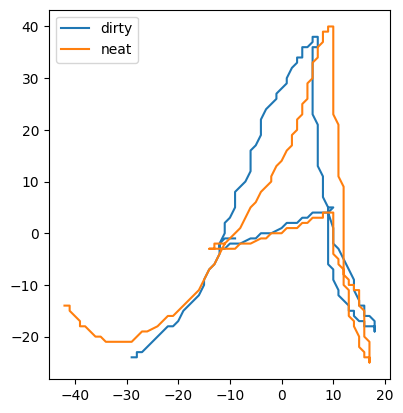

In [6]:
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
# print(features.shape, labels.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, label="dirty")
ax.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, label="neat")
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

num_epochs = 10
learning_rate = 0.0001
batch_size = 1

model = UNet(3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(dataloader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'model.ckpt')


cpu
Epoch [1/20], Step [1/72], Loss: 264.9413
Epoch [1/20], Step [2/72], Loss: 65.4722
Epoch [1/20], Step [3/72], Loss: 203.4257
Epoch [1/20], Step [4/72], Loss: 104.6067
Epoch [1/20], Step [5/72], Loss: 209.8887
Epoch [1/20], Step [6/72], Loss: 61.7581
Epoch [1/20], Step [7/72], Loss: 187.5115
Epoch [1/20], Step [8/72], Loss: 111.2622
Epoch [1/20], Step [9/72], Loss: 192.2319
Epoch [1/20], Step [10/72], Loss: 55.9063
Epoch [1/20], Step [11/72], Loss: 170.7782
Epoch [1/20], Step [12/72], Loss: 221.7114
Epoch [1/20], Step [13/72], Loss: 107.3640
Epoch [1/20], Step [14/72], Loss: 214.1810
Epoch [1/20], Step [15/72], Loss: 161.5174
Epoch [1/20], Step [16/72], Loss: 124.6963
Epoch [1/20], Step [17/72], Loss: 147.1413
Epoch [1/20], Step [18/72], Loss: 48.5950
Epoch [1/20], Step [19/72], Loss: 150.1879
Epoch [1/20], Step [20/72], Loss: 305.9287
Epoch [1/20], Step [21/72], Loss: 128.5114
Epoch [1/20], Step [22/72], Loss: 98.3854
Epoch [1/20], Step [23/72], Loss: 196.0974
Epoch [1/20], Step [2

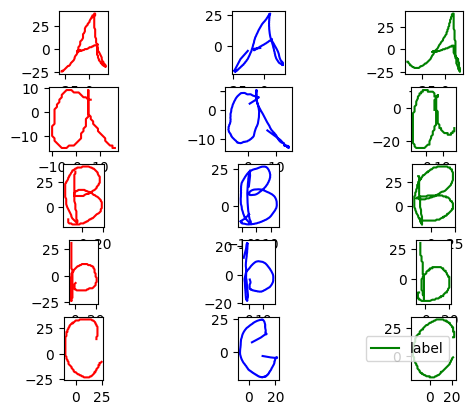

In [15]:
dataiter = iter(dataloader)
data = next(dataiter)
data2 = next(dataiter)
data3 = next(dataiter)
data4 = next(dataiter)
data5 = next(dataiter)
features, labels = data
features2, labels2 = data2
features3, labels3 = data3
features4, labels4 = data4
features5, labels5 = data5
output_features = model(features)
output_features2 = model(features2)
output_features3 = model(features3)
output_features4 = model(features4)
output_features5 = model(features5)

fig = plt.figure()
ax = fig.add_subplot(531)
ax2 = fig.add_subplot(532)
ax3 = fig.add_subplot(533)
ax4 = fig.add_subplot(534)
ax5 = fig.add_subplot(535)
ax6 = fig.add_subplot(536)
ax7 = fig.add_subplot(537)
ax8 = fig.add_subplot(538)
ax9 = fig.add_subplot(539)
ax10 = fig.add_subplot(5,3,10)
ax11 = fig.add_subplot(5,3,11)
ax12 = fig.add_subplot(5,3,12)
ax13 = fig.add_subplot(5,3,13)
ax14 = fig.add_subplot(5,3,14)
ax15 = fig.add_subplot(5,3,15)

ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, color="red", label="input")
ax2.plot(output_features[0].detach().numpy()[0], output_features[0].detach().numpy()[1]*-1, color="blue", label="output")
ax3.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, color="green", label="label")

ax4.plot(features2[0].numpy()[0], features2[0].numpy()[1]*-1, color="red", label="input")
ax5.plot(output_features2[0].detach().numpy()[0], output_features2[0].detach().numpy()[1]*-1, color="blue", label="output")
ax6.plot(labels2[0].numpy()[0], labels2[0].numpy()[1]*-1, color="green", label="label")

ax7.plot(features3[0].numpy()[0], features3[0].numpy()[1]*-1, color="red", label="input")
ax8.plot(output_features3[0].detach().numpy()[0], output_features3[0].detach().numpy()[1]*-1, color="blue", label="output")
ax9.plot(labels3[0].numpy()[0], labels3[0].numpy()[1]*-1, color="green", label="label")

ax10.plot(features4[0].numpy()[0], features4[0].numpy()[1]*-1, color="red", label="input")
ax11.plot(output_features4[0].detach().numpy()[0], output_features4[0].detach().numpy()[1]*-1, color="blue", label="output")
ax12.plot(labels4[0].numpy()[0], labels4[0].numpy()[1]*-1, color="green", label="label")

ax13.plot(features5[0].numpy()[0], features5[0].numpy()[1]*-1, color="red", label="input")
ax14.plot(output_features5[0].detach().numpy()[0], output_features5[0].detach().numpy()[1]*-1, color="blue", label="output")
ax15.plot(labels5[0].numpy()[0], labels5[0].numpy()[1]*-1, color="green", label="label")

ax.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')
ax4.set_aspect('equal', adjustable='box')
ax5.set_aspect('equal', adjustable='box')
ax6.set_aspect('equal', adjustable='box')
ax7.set_aspect('equal', adjustable='box')
ax8.set_aspect('equal', adjustable='box')
ax9.set_aspect('equal', adjustable='box')
ax10.set_aspect('equal', adjustable='box')
ax11.set_aspect('equal', adjustable='box')
ax12.set_aspect('equal', adjustable='box')
ax13.set_aspect('equal', adjustable='box')
ax14.set_aspect('equal', adjustable='box')
ax15.set_aspect('equal', adjustable='box')

plt.legend()
plt.show()